In [1]:

"""

=============================================
Nypipe reanalysis - version 2
=============================================

This script is contains a preprocessing workflow aimed at replicating a previous
FSL-based model incorporating saccadic eyemovements to localize functional
regions of the brain involved in eyemovement generation and execution. It
further generates BIDS compliant events files for saccadic and confounding
events.

"""

from __future__ import print_function
from __future__ import division
from builtins import str
from builtins import range

import os
import nipype.interfaces.io as nio
import nipype.interfaces.fsl as fsl
from nipype.interfaces import utility as util
import nipype.pipeline.engine as pe
import nipype.algorithms.modelgen as model
from nipype import SelectFiles, DataSink, Function, LooseVersion
import nipype.algorithms.rapidart as ra
from nipype.utils.filemanip import filename_to_list

from nipype.workflows.fmri.fsl import (#create_featreg_preproc,
                                       create_modelfit_workflow,
                                       create_fixed_effects_flow)

from os.path import join as opj
import json
from glob import glob


def create_featreg_preproc(name='featpreproc',
                           highpass=True,
                           whichvol='middle',
                           whichrun=0):
    """Create a FEAT preprocessing workflow with registration to one volume of
    the first run. If whichvol = None and/or whichrun = None, no motion
    correction will be performed and the FEAT preprocessing workflow will not
    return outputspec.reference, outputspec.realigned_files, and
    outputspec.motion_plots.

    Parameters
    ----------

    ::

        name : name of workflow (default: featpreproc)
        highpass : boolean (default: True)
        whichvol : which volume of the first run to register to ('first', 'middle', 'last', 'mean', None)
        whichrun : which run to draw reference volume from (integer index or 'first', 'middle', 'last' or None)

    Inputs::

        inputspec.func : functional runs (filename or list of filenames)
        inputspec.fwhm : fwhm for smoothing with SUSAN
        inputspec.highpass : HWHM in TRs (if created with highpass=True)

    Outputs::

        outputspec.reference : volume to which runs are realigned
        outputspec.motion_parameters : motion correction parameters
        outputspec.realigned_files : motion corrected files
        outputspec.motion_plots : plots of motion correction parameters
        outputspec.mask : mask file used to mask the brain
        outputspec.smoothed_files : smoothed functional data
        outputspec.highpassed_files : highpassed functional data (if highpass=True)
        outputspec.mean : mean file

    Example
    -------

    >>> preproc = create_featreg_preproc()
    >>> preproc.inputs.inputspec.func = ['f3.nii', 'f5.nii']
    >>> preproc.inputs.inputspec.fwhm = 5
    >>> preproc.inputs.inputspec.highpass = 128./(2*2.5)
    >>> preproc.base_dir = '/tmp'
    >>> preproc.run() # doctest: +SKIP

    >>> preproc = create_featreg_preproc(highpass=False, whichvol='mean')
    >>> preproc.inputs.inputspec.func = 'f3.nii'
    >>> preproc.inputs.inputspec.fwhm = 5
    >>> preproc.base_dir = '/tmp'
    >>> preproc.run() # doctest: +SKIP
    """

    version = 0
    if fsl.Info.version() and \
            LooseVersion(fsl.Info.version()) > LooseVersion('5.0.6'):
        version = 507

    featpreproc = pe.Workflow(name=name)

    """
    Derive boolean motion correction parameter from the given parameters
    """
    if (whichrun != None) & (whichvol != None):
        motion_corr = True
    else:
        motion_corr = False

    """
    Set up a node to define all inputs required for the preprocessing workflow

    """
    output_fields=[
                    'mask', 'smoothed_files',
                    'mean', 'functional_files'
            ]

    input_fields=[
                    'func', 'fwhm'
            ]

    if highpass:
        output_fields += ['highpassed_files']
        input_fields += ['highpass']
        inputnode = pe.Node(
            interface=util.IdentityInterface(
                fields=input_fields),
            name='inputspec')

        if motion_corr:
            output_fields += ['reference', 'motion_parameters',
            'realigned_files']
            outputnode = pe.Node(
                interface=util.IdentityInterface(fields=output_fields),
                name='outputspec')

        else:
            outputnode = pe.Node(
                interface=util.IdentityInterface(fields=output_fields),
                name='outputspec')

    else:
        inputnode = pe.Node(
            interface=util.IdentityInterface(fields=input_fields),
            name='inputspec')

        if motion_corr:
            output_fields += ['reference', 'motion_parameters',
            'realigned_files']
        outputnode = pe.Node(
            interface=util.IdentityInterface(fields=output_fields),
            name='outputspec')
    """
    Set up a node to define outputs for the preprocessing workflow

    """
    """
    Convert functional images to float representation. Since there can
    be more than one functional run we use a MapNode to convert each
    run.
    """

    img2float = pe.MapNode(
        interface=fsl.ImageMaths(
            out_data_type='float', op_string='', suffix='_dtype'),
        iterfield=['in_file'],
        name='img2float')
    featpreproc.connect(inputnode, 'func', img2float, 'in_file')

    if motion_corr:
        """
        Extract the middle (or what whichvol points to) volume of the first run as the reference
        """

        if whichvol != 'mean':
            extract_ref = pe.Node(
                interface=fsl.ExtractROI(t_size=1),
                iterfield=['in_file'],
                name='extractref')
            featpreproc.connect(img2float, ('out_file', pickrun, whichrun),
                                extract_ref, 'in_file')
            featpreproc.connect(img2float, ('out_file', pickvol, 0, whichvol),
                                extract_ref, 't_min')
            featpreproc.connect(extract_ref, 'roi_file', outputnode, 'reference')
        """
        Realign the functional runs to the reference (`whichvol` volume of first run)
        """

        motion_correct = pe.MapNode(
            interface=fsl.MCFLIRT(
                save_mats=True, save_plots=True, interpolation='spline'),
            name='realign',
            iterfield=['in_file'])
        featpreproc.connect(img2float, 'out_file', motion_correct, 'in_file')
        if whichvol != 'mean':
            featpreproc.connect(extract_ref, 'roi_file', motion_correct,
                                'ref_file')
        else:
            motion_correct.inputs.mean_vol = True
            featpreproc.connect(motion_correct, ('mean_img', pickrun, whichrun),
                                outputnode, 'reference')

        featpreproc.connect(motion_correct, 'par_file', outputnode,
                            'motion_parameters')
        featpreproc.connect(motion_correct, 'out_file', outputnode,
                            'realigned_files')
        """
        Plot the estimated motion parameters
        """

        plot_motion = pe.MapNode(
            interface=fsl.PlotMotionParams(in_source='fsl'),
            name='plot_motion',
            iterfield=['in_file'])
        plot_motion.iterables = ('plot_type', ['rotations', 'translations'])
        featpreproc.connect(motion_correct, 'par_file', plot_motion, 'in_file')
        featpreproc.connect(plot_motion, 'out_file', outputnode, 'motion_plots')
        """
        Extract the mean volume of the first functional run
        """
    else:
        featpreproc.connect(img2float, 'out_file', outputnode,
                            'functional_files')
        #TODO: check whether this is really necessary

    if motion_corr:
        meanfunc = pe.Node(
            interface=fsl.ImageMaths(op_string='-Tmean', suffix='_mean'),
            name='meanfunc')
        featpreproc.connect(motion_correct, ('out_file', pickrun, whichrun),
                            meanfunc, 'in_file')
    else:
        meanfunc = pe.MapNode(
            interface=fsl.ImageMaths(op_string='-Tmean', suffix='_mean'),
            iterfield=['in_file'],
            name='meanfunc')
        featpreproc.connect(img2float, 'out_file', meanfunc, 'in_file')

    """
    Strip the skull from the mean functional to generate a mask
    """
    if motion_corr:
        meanfuncmask = pe.Node(
            interface=fsl.BET(mask=True, no_output=True, frac=0.3),
            name='meanfuncmask')
    else:
        meanfuncmask = pe.MapNode(
            interface=fsl.BET(mask=True, no_output=True, frac=0.3),
            iterfield=['in_file'],
            name='meanfuncmask')

    featpreproc.connect(meanfunc, 'out_file', meanfuncmask, 'in_file')
    """
    Mask the functional runs with the extracted mask
    """
    if motion_corr:
        maskfunc = pe.MapNode(
            interface=fsl.ImageMaths(suffix='_bet', op_string='-mas'),
            iterfield=['in_file'],
            name='maskfunc')
        featpreproc.connect(motion_correct, 'out_file', maskfunc, 'in_file')
    else:
        maskfunc = pe.MapNode(
            interface=fsl.ImageMaths(suffix='_bet', op_string='-mas'),
            iterfield=['in_file', 'in_file2'],
            name='maskfunc')
        featpreproc.connect(img2float, 'out_file', maskfunc, 'in_file')

    featpreproc.connect(meanfuncmask, 'mask_file', maskfunc, 'in_file2')
    """
    Determine the 2nd and 98th percentile intensities of each functional run
    """

    getthresh = pe.MapNode(
        interface=fsl.ImageStats(op_string='-p 2 -p 98'),
        iterfield=['in_file'],
        name='getthreshold')
    featpreproc.connect(maskfunc, 'out_file', getthresh, 'in_file')
    """
    Threshold the first run of the functional data at 10% of the 98th percentile
    """

    threshold = pe.MapNode(
        interface=fsl.ImageMaths(out_data_type='char', suffix='_thresh'),
        iterfield=['in_file', 'op_string'],
        name='threshold')
    featpreproc.connect(maskfunc, 'out_file', threshold, 'in_file')
    """
    Define a function to get 10% of the intensity
    """

    featpreproc.connect(getthresh, ('out_stat', getthreshop), threshold,
                        'op_string')
    """
    Determine the median value of the functional runs using the mask
    """

    medianval = pe.MapNode(
        interface=fsl.ImageStats(op_string='-k %s -p 50'),
        iterfield=['in_file', 'mask_file'],
        name='medianval')

    if motion_corr:
        featpreproc.connect(motion_correct, 'out_file', medianval, 'in_file')
    else:
        featpreproc.connect(img2float, 'out_file', medianval, 'in_file')

    featpreproc.connect(threshold, 'out_file', medianval, 'mask_file')

    """
    Dilate the mask
    """

    dilatemask = pe.MapNode(
        interface=fsl.ImageMaths(suffix='_dil', op_string='-dilF'),
        iterfield=['in_file'],
        name='dilatemask')
    featpreproc.connect(threshold, 'out_file', dilatemask, 'in_file')
    featpreproc.connect(dilatemask, 'out_file', outputnode, 'mask')
    """
    Mask the motion corrected functional runs with the dilated mask
    """

    maskfunc2 = pe.MapNode(
        interface=fsl.ImageMaths(suffix='_mask', op_string='-mas'),
        iterfield=['in_file', 'in_file2'],
        name='maskfunc2')

    if motion_corr:
        featpreproc.connect(motion_correct, 'out_file', maskfunc2, 'in_file')
    else:
        featpreproc.connect(img2float, 'out_file', maskfunc2, 'in_file')
    featpreproc.connect(dilatemask, 'out_file', maskfunc2, 'in_file2')

    """
    Smooth each run using SUSAN with the brightness threshold set to 75%
    of the median value for each run and a mask constituting the mean
    functional
    """

    smooth = create_susan_smooth()

    featpreproc.connect(inputnode, 'fwhm', smooth, 'inputnode.fwhm')
    featpreproc.connect(maskfunc2, 'out_file', smooth, 'inputnode.in_files')
    featpreproc.connect(dilatemask, 'out_file', smooth, 'inputnode.mask_file')
    """
    Mask the smoothed data with the dilated mask
    """

    maskfunc3 = pe.MapNode(
        interface=fsl.ImageMaths(suffix='_mask', op_string='-mas'),
        iterfield=['in_file', 'in_file2'],
        name='maskfunc3')
    featpreproc.connect(smooth, 'outputnode.smoothed_files', maskfunc3,
                        'in_file')

    featpreproc.connect(dilatemask, 'out_file', maskfunc3, 'in_file2')

    concatnode = pe.Node(interface=util.Merge(2), name='concat')
    featpreproc.connect(maskfunc2, ('out_file', tolist), concatnode, 'in1')
    featpreproc.connect(maskfunc3, ('out_file', tolist), concatnode, 'in2')
    """
    The following nodes select smooth or unsmoothed data depending on the
    fwhm. This is because SUSAN defaults to smoothing the data with about the
    voxel size of the input data if the fwhm parameter is less than 1/3 of the
    voxel size.
    """
    selectnode = pe.Node(interface=util.Select(), name='select')

    featpreproc.connect(concatnode, 'out', selectnode, 'inlist')

    featpreproc.connect(inputnode, ('fwhm', chooseindex), selectnode, 'index')
    featpreproc.connect(selectnode, 'out', outputnode, 'smoothed_files')
    """
    Scale the median value of the run is set to 10000
    """

    meanscale = pe.MapNode(
        interface=fsl.ImageMaths(suffix='_gms'),
        iterfield=['in_file', 'op_string'],
        name='meanscale')
    featpreproc.connect(selectnode, 'out', meanscale, 'in_file')
    """
    Define a function to get the scaling factor for intensity normalization
    """

    featpreproc.connect(medianval, ('out_stat', getmeanscale), meanscale,
                        'op_string')
    """
    Generate a mean functional image from the first run
    """

    meanfunc3 = pe.MapNode(
        interface=fsl.ImageMaths(op_string='-Tmean', suffix='_mean'),
        iterfield=['in_file'],
        name='meanfunc3')

    if motion_corr:
        featpreproc.connect(meanscale, ('out_file', pickrun, whichrun), meanfunc3,
                        'in_file')
    else:
        featpreproc.connect(meanscale, 'out_file', meanfunc3, 'in_file')
    featpreproc.connect(meanfunc3, 'out_file', outputnode, 'mean')
    """
    Perform temporal highpass filtering on the data
    """

    if highpass:
        highpass = pe.MapNode(
            interface=fsl.ImageMaths(suffix='_tempfilt'),
            iterfield=['in_file'],
            name='highpass')
        featpreproc.connect(inputnode, ('highpass', highpass_operand),
                            highpass, 'op_string')
        featpreproc.connect(meanscale, 'out_file', highpass, 'in_file')

        if version < 507:
            featpreproc.connect(highpass, 'out_file', outputnode,
                                'highpassed_files')
        else:
            """
            Add back the mean removed by the highpass filter operation as of FSL 5.0.7
            """
            meanfunc4 = pe.MapNode(
                interface=fsl.ImageMaths(op_string='-Tmean', suffix='_mean'),
                iterfield=['in_file'],
                name='meanfunc4')

            featpreproc.connect(meanscale, 'out_file', meanfunc4, 'in_file')
            addmean = pe.MapNode(
                interface=fsl.BinaryMaths(operation='add'),
                iterfield=['in_file', 'operand_file'],
                name='addmean')
            featpreproc.connect(highpass, 'out_file', addmean, 'in_file')
            featpreproc.connect(meanfunc4, 'out_file', addmean, 'operand_file')
            featpreproc.connect(addmean, 'out_file', outputnode,
                                'highpassed_files')

    return featpreproc



In [2]:

def getthreshop(thresh):
    return ['-thr %.10f -Tmin -bin' % (0.1 * val[1]) for val in thresh]


def pickrun(files, whichrun):
    """pick file from list of files"""

    filemap = {'first': 0, 'last': -1, 'middle': len(files) // 2}

    if isinstance(files, list):

        # whichrun is given as integer
        if isinstance(whichrun, int):
            return files[whichrun]
        # whichrun is given as string
        elif isinstance(whichrun, str):
            if whichrun not in filemap.keys():
                raise (KeyError, 'Sorry, whichrun must be either integer index'
                       'or string in form of "first", "last" or "middle')
            else:
                return files[filemap[whichrun]]
    else:
        # in case single file name is given
        return files


def pickfirst(files):
    if isinstance(files, list):
        return files[0]
    else:
        return files


def pickmiddle(files):
    from nibabel import load
    import numpy as np
    from nipype.utils import NUMPY_MMAP
    middlevol = []
    for f in files:
        middlevol.append(int(np.ceil(load(f, mmap=NUMPY_MMAP).shape[3] / 2)))
    return middlevol


def pickvol(filenames, fileidx, which):
    from nibabel import load
    import numpy as np
    from nipype.utils import NUMPY_MMAP
    if which.lower() == 'first':
        idx = 0
    elif which.lower() == 'middle':
        idx = int(
            np.ceil(load(filenames[fileidx], mmap=NUMPY_MMAP).shape[3] / 2))
    elif which.lower() == 'last':
        idx = load(filenames[fileidx]).shape[3] - 1
    else:
        raise Exception('unknown value for volume selection : %s' % which)
    return idx


def getbtthresh(medianvals):
    return [0.75 * val for val in medianvals]


def chooseindex(fwhm):
    if fwhm < 1:
        return [0]
    else:
        return [1]


def getmeanscale(medianvals):
    return ['-mul %.10f' % (10000. / val) for val in medianvals]


def getusans(x):
    return [[tuple([val[0], 0.75 * val[1]])] for val in x]


tolist = lambda x: [x]
highpass_operand = lambda x: '-bptf %.10f -1' % x




In [3]:
def create_susan_smooth(name="susan_smooth", separate_masks=True):
    """Create a SUSAN smoothing workflow

    Parameters
    ----------

    ::

        name : name of workflow (default: susan_smooth)
        separate_masks : separate masks for each run

    Inputs::

        inputnode.in_files : functional runs (filename or list of filenames)
        inputnode.fwhm : fwhm for smoothing with SUSAN (float or list of floats)
        inputnode.mask_file : mask used for estimating SUSAN thresholds (but not for smoothing)

    Outputs::

        outputnode.smoothed_files : functional runs (filename or list of filenames)

    Example
    -------

    >>> smooth = create_susan_smooth()
    >>> smooth.inputs.inputnode.in_files = 'f3.nii'
    >>> smooth.inputs.inputnode.fwhm = 5
    >>> smooth.inputs.inputnode.mask_file = 'mask.nii'
    >>> smooth.run() # doctest: +SKIP

    """

    # replaces the functionality of a "for loop"
    def cartesian_product(fwhms, in_files, usans, btthresh):
        from nipype.utils.filemanip import ensure_list
        # ensure all inputs are lists
        in_files = ensure_list(in_files)
        fwhms = [fwhms] if isinstance(fwhms, (int, float)) else fwhms
        # create cartesian product lists (s_<name> = single element of list)
        cart_in_file = [
            s_in_file for s_in_file in in_files for s_fwhm in fwhms
        ]
        cart_fwhm = [s_fwhm for s_in_file in in_files for s_fwhm in fwhms]
        cart_usans = [s_usans for s_usans in usans for s_fwhm in fwhms]
        cart_btthresh = [
            s_btthresh for s_btthresh in btthresh for s_fwhm in fwhms
        ]

        return cart_in_file, cart_fwhm, cart_usans, cart_btthresh

    susan_smooth = pe.Workflow(name=name)
    """
    Set up a node to define all inputs required for the preprocessing workflow

    """

    inputnode = pe.Node(
        interface=util.IdentityInterface(
            fields=['in_files', 'fwhm', 'mask_file']),
        name='inputnode')
    """
    Smooth each run using SUSAN with the brightness threshold set to 75%
    of the median value for each run and a mask consituting the mean
    functional
    """

    multi_inputs = pe.Node(
        util.Function(
            function=cartesian_product,
            output_names=[
                'cart_in_file', 'cart_fwhm', 'cart_usans', 'cart_btthresh'
            ]),
        name='multi_inputs')

    smooth = pe.MapNode(
        interface=fsl.SUSAN(),
        iterfield=['in_file', 'brightness_threshold', 'usans', 'fwhm'],
        name='smooth')
    """
    Determine the median value of the functional runs using the mask
    """

    if separate_masks:
        median = pe.MapNode(
            interface=fsl.ImageStats(op_string='-k %s -p 50'),
            iterfield=['in_file', 'mask_file'],
            name='median')
    else:
        median = pe.MapNode(
            interface=fsl.ImageStats(op_string='-k %s -p 50'),
            iterfield=['in_file'],
            name='median')
    susan_smooth.connect(inputnode, 'in_files', median, 'in_file')
    susan_smooth.connect(inputnode, 'mask_file', median, 'mask_file')
    """
    Mask the motion corrected functional runs with the dilated mask
    """

    if separate_masks:
        mask = pe.MapNode(
            interface=fsl.ImageMaths(suffix='_mask', op_string='-mas'),
            iterfield=['in_file', 'in_file2'],
            name='mask')
    else:
        mask = pe.MapNode(
            interface=fsl.ImageMaths(suffix='_mask', op_string='-mas'),
            iterfield=['in_file'],
            name='mask')
    susan_smooth.connect(inputnode, 'in_files', mask, 'in_file')
    susan_smooth.connect(inputnode, 'mask_file', mask, 'in_file2')
    """
    Determine the mean image from each functional run
    """

    meanfunc = pe.MapNode(
        interface=fsl.ImageMaths(op_string='-Tmean', suffix='_mean'),
        iterfield=['in_file'],
        name='meanfunc2')
    susan_smooth.connect(mask, 'out_file', meanfunc, 'in_file')
    """
    Merge the median values with the mean functional images into a coupled list
    """

    merge = pe.Node(interface=util.Merge(2, axis='hstack'), name='merge')
    susan_smooth.connect(meanfunc, 'out_file', merge, 'in1')
    susan_smooth.connect(median, 'out_stat', merge, 'in2')
    """
    Define a function to get the brightness threshold for SUSAN
    """

    susan_smooth.connect([
        (inputnode, multi_inputs, [('in_files', 'in_files'), ('fwhm',
                                                              'fwhms')]),
        (median, multi_inputs, [(('out_stat', getbtthresh), 'btthresh')]),
        (merge, multi_inputs, [(('out', getusans), 'usans')]),
        (multi_inputs, smooth,
         [('cart_in_file', 'in_file'), ('cart_fwhm', 'fwhm'),
          ('cart_btthresh', 'brightness_threshold'), ('cart_usans', 'usans')]),
    ])

    outputnode = pe.Node(
        interface=util.IdentityInterface(fields=['smoothed_files']),
        name='outputnode')

    susan_smooth.connect(smooth, 'smoothed_file', outputnode, 'smoothed_files')

    return susan_smooth




In [4]:

"""
Define helpful functions
"""
def ev3_info(subject_id,
            run_id,
            confinfo,
            experiment_dir,
            session_id,
            task_id,
            eyemovement_dir): #TODO: information in infonode and argparse
    """
    This function creates ev3 files from classified/labeled eyemovements,
    extracts information from the ev3 files about 'conditions', onsets and
    durations and returns everything in a Bunch structure.
    "subject_id" should have format 'sub-01'
    "run_id" should have format 'run-1'
    "ev3info" should be a path
    "confinfo" should be a path
    """
    import pandas as pd
    import numpy as np
    from os.path import join as opj
    import os
    import glob
    import math
   ####### from nipype.interfaces.base import Bunch
    #create ev3 files from scratch
    path = opj(experiment_dir, subject_id, session_id, eyemovement_dir, '*{}_desc-remodnav_events*.tsv'.format(run_id))
    infile = glob.glob(path)[0]

    subs = ["sub-01", "sub-02", "sub-03", "sub-04", "sub-05", "sub-06", "sub-09",
    "sub-10", "sub-14", "sub-15", "sub-16", "sub-17", "sub-18", "sub-19", "sub-20"]

    if subject_id in subs:
        conversion_factor = 0.018558123256059607
    #this would be for lab subjects
    else:
        conversion_factor = 0.026671197202630847

   #length and angle calculation basics
    def cart2pol(x, y):
        rho = np.sqrt(x**2 + y**2)
        theta = np.arctan2(y,x)
        return(rho, theta)

    #length in visual degrees and angle basics
    def calc_polar(x_start, x_end, y_start, y_end, conversion_factor):
        '''function takes start and end coordinates in x and y direction and the
        appropriate conversion factor (lab or mri)'''
        #calculate saccade length from raw eye tracking data
        x, y = x_end-x_start, y_end - y_start
        #transform via cart2pol. rho = length, theta = angle
        rho, theta = cart2pol(x, y)
        #convert rho in px into visual degrees
        vis_deg = rho * conversion_factor
        return vis_deg, theta

    #extract and calculate necessary measures
    def polar_coordinates(data, conversion_factor):
        '''data is an array with columns time, x_start, x_end, y_start, y_end.
        Conversion factor is either mri_deg_per_px or lab_deg_per_px'''
        angles = []
        lengths = []
        time = data['onset']    #extract time from data (first col)
        duration = data['duration']      #extract duration from data
        for row in data:
            length, angle = calc_polar(row['start_x'], row['end_x'], row['start_y'],
                            row['end_y'], conversion_factor)
            angles.append(angle)
            lengths.append(length)
        return time.tolist(), duration.tolist(), angles, lengths


    df = np.recfromcsv(infile, delimiter ='\t',
                        dtype = {'names':('onset', 'duration', 'label',
                        'start_x', 'start_y', 'end_x', 'end_y', 'amp',
                        'peak_vel', 'med_vel', 'avg_vel'),
                        'formats':('f8', 'f8', 'U10', 'f8', 'f8', 'f8', 'f8',
                        'f8', 'f8', 'f8', 'f8')})
    #take all types of saccades
    data = df[(df['label']=='SACC') | (df['label']=='ISAC')]
    #calculate angles and lengths, extract times and durations
    time, duration, angles, lengths = polar_coordinates(data, conversion_factor)
    trial_dummy = np.repeat('nothing', len(time))
    trans_data = np.column_stack((time, duration, angles, lengths))
    up_idx = np.where(np.logical_and(trans_data[:,2] >= 1.308996939,
    trans_data[:,2]<= 1.8325957146))[0]
    down_idx = np.where(np.logical_and(trans_data[:,2] <= -1.308996939,
    trans_data[:,2]>= -1.8325957146))[0]
    left_idx = np.where(np.logical_or(trans_data[:,2] >= 2.8797932658,
    trans_data[:,2]<= -2.8797932658))[0]
    right_idx = np.where(np.logical_and(trans_data[:,2] <= 0.2617993878,
    trans_data[:,2]>= -0.2617993878))[0]
    for i in up_idx:
        trial_dummy[i]="UP"
    for i in down_idx:
        trial_dummy[i]="DOWN"
    for i in left_idx:
        trial_dummy[i]="LEFT"
    for i in right_idx:
        trial_dummy[i]="RIGHT"
    #combine into dataframe
    rec = np.core.records.fromarrays(trans_data.transpose(), names='onset, duration, angle, amplitude', formats='f8, f8, f8, f8')
    df_saccs = pd.DataFrame.from_records(rec)
    df_saccs['trial_type']=trial_dummy.tolist()

    con_lrdiff_path = opj(experiment_dir, subject_id, confinfo, '*{}*desc-lrdiff*'.format(run_id))
    con_lrdiff = glob.glob(con_lrdiff_path)[0]
    lrdiff = pd.read_csv(con_lrdiff, sep=" ", header=None, names=['onset', 'duration', 'amplitude'])
    trial_dummy_lrdiff = np.repeat('LRDIFF', len(lrdiff))
    lrdiff['trial_type']=trial_dummy_lrdiff

    con_rms_path = opj(experiment_dir, subject_id, confinfo, '*{}*desc-rms*'.format(run_id))
    con_rms=glob.glob(con_rms_path)[0]
    rms = pd.read_csv(con_rms, sep=" ", header=None, names=['onset', 'duration',
    'amplitude'])
    trial_dummy_rms=np.repeat('RMS', len(rms))
    rms['trial_type']=trial_dummy_rms

    con_pd_path = opj(experiment_dir, subject_id, confinfo, '*{}*desc-pd*'.format(run_id))
    con_pd=glob.glob(con_pd_path)[0]
    cpd = pd.read_csv(con_pd, sep='\t', header=None, names=['onset', 'duration',
    'amplitude'])
    trial_dummy_cpd=np.repeat('PD', len(cpd))
    cpd['trial_type']=trial_dummy_cpd

    dfs = [df_saccs, lrdiff, rms, cpd]
    df_event = pd.concat(dfs)
    #reindexing
    df_events = df_event.reindex(df_saccs.columns, axis=1)
    #drop angle column
    df_events.drop('angle', axis='columns')
    df_events=df_events.drop('angle', axis='columns')

    outfilepath=opj(experiment_dir, subject_id, confinfo)
    df_events.to_csv(opj(outfilepath,'{}_{}_{}_{}_events.tsv'.format(subject_id,
    session_id, task_id, run_id)), header=True, index=False, sep='\t')
    return df_events




In [5]:
import os.path
subject_id = 'sub-01'
run_id = 'run-1'
confinfo = 'ses-movie/func'
experiment_dir = os.path.abspath('../')
session_id = 'ses-movie'
task_id = 'task-avmovie'
eyemovement_dir='eyetrack'


ev3_info(subject_id=subject_id, run_id=run_id, confinfo=confinfo, experiment_dir=experiment_dir, session_id = session_id, task_id = task_id, eyemovement_dir = eyemovement_dir)


,onset,duration,amplitude,trial_type
0,0.043,0.016,2.613387,nothing
1,0.380,0.031,5.004224,DOWN
2,0.789,0.021,3.681274,nothing
3,1.956,0.018,4.659729,nothing
4,2.681,0.016,3.596612,RIGHT
5,3.248,0.024,4.147480,nothing
6,4.323,0.025,4.251269,LEFT
7,4.612,0.026,4.057786,nothing
8,4.951,0.035,4.115556,nothing
9,5.762,0.102,0.410437,nothing


In [6]:
os.path.abspath('../')
path = opj(experiment_dir, subject_id, eyemovement_dir, '*{}_desc-remodnav_events*.tsv'.format(run_id))
path

'/home/adina/Documents/MasterMagdeburg/USA_Dartmouth/content/localizer_project/BIDS_sacc/sub-01/eyetrack/*run-1_desc-remodnav_events*.tsv'

In [7]:

def num_copes(files):
    return len(files)


pickfirst = lambda x: x[0]



In [8]:

def preprocess_forrest(experiment_dir,
                        eyemovement_dir,
                        confinfo,
                        subject_id=None,
                        run_id=None,
                        fwhm=5.0,
                        run_num=8,
                        hpcutoff=50.,
                        session_id=None,
                        task_id=None):
    """
    create a workflow for preprocessing and saving the studyforrest data
    """
    preproc = create_featreg_preproc(whichvol=None)
    preproc.inputs.inputspec.fwhm = fwhm
    preproc.inputs.inputspec.highpass = hpcutoff

    if subject_id:
        subject_list=[subject_id]
    else:
        subject_list = sorted([path.split(os.path.sep)[-1] for path in
                            glob(os.path.join(experiment_dir, 'sub*'))])

    if run_id:
        run_list=[run_id]
    else:
        run_list = []
        for i in range(1, run_num+1):
            run_list.append('run-' + str(i))

    if session_id:
        session_list=[session_id]
    else:
        session_list = ['ses-movie']

    if task_id:
        task_list=[task_id]
    else:
        task_list = ['task_avmovie']

    info_source = pe.Node(
        util.IdentityInterface(fields=['subject_id',
                                    'session_id',
                                    'task_id',
                                    'run_id'],
                                        mandatory_inputs=False),
        name='infosource')

    info_source.iterables = [('subject_id', subject_list),
                            ('session_id', session_list),
                            ('task_id', task_list),
                            ('run_id', run_list)]

    templates = {#'anat':'inputs/tnt/{subject_id}/t1w/brain.nii.gz',
                 'func':'{subject_id}/{session_id}/func/sub-*_task-avmovie_{run_id}_bold.nii.gz'}

    sf = pe.Node(SelectFiles(templates),
              name='selectfiles')
    sf.inputs.base_directory=experiment_dir

    datasink = pe.Node(DataSink(),
                  name='datasink')
    datasink.inputs.base_directory = experiment_dir


    def get_preproc_subs(subject_id, session_id, task_id, run_id):
        subs = [('_subject_id_{}_'.format(subject_id), '')]
        subs.append(('task_id_{}'.format(task_id), ''))
        subs.append(('_run_id_{}'.format(run_id), ''))
        subs.append(('_session_id_{}'.format(session_id), ''))
        subs.append(('_addmean0', ''))
        subs.append(('_dilatemask0', ''))
        subs.append(('_maskfunc30', ''))
        subs.append(('_meanfunc30', ''))
        subs.append(('bold_dtype_bet_thresh_dil', 'desc-mask'))
        subs.append(('bold_dtype_mask_smooth_mask_gms', 'desc-mean'))
        subs.append(('bold_dtype_mask_smooth_mask', 'desc-smooth'))
        subs.append(('bold_dtype_mask_smooth_mask gms_tempfilt_maths',
        'desc-highpass'))
        subs.append(('_mean', ''))
        subs.append(('mean_tempfilt_maths','highpass'))
        return subs

    subsgenpreproc = pe.Node(util.Function(input_names=['subject_id',
                                                        'session_id',
                                                        'task_id',
                                                        'run_id'],
                                        output_names=['substitutions'],
                                        function=get_preproc_subs),
                            name='subsgenpreproc')

    getev3info = pe.Node(Function(input_names=['subject_id',
                                                'run_id',
                                                'confinfo',
                                                'experiment_dir',
                                                'session_id',
                                                'task_id',
                                                'eyemovement_dir'],
                               output_names=['df_events'],
                               function=ev3_info),
                     name='getev3info')


    getev3info.inputs.confinfo=confinfo
    getev3info.inputs.experiment_dir=experiment_dir
    getev3info.inputs.eyemovement_dir=eyemovement_dir


    def ds_container_gen(subject_id):
        """
        Generate container for DataSink
        """
        from os.path import join as opj
        container=opj(subject_id, 'ses-movie')
        return container
    
    ds_container = pe.Node(util.Function(input_names=['subject_id'],
                                        output_names=['container'],
                                        function=ds_container_gen),
                          name='ds_container')

    
    preprocwf = pe.Workflow(name='preprocessing')
    preprocwf.connect([(info_source, sf, [('subject_id', 'subject_id'),
                                            ('run_id', 'run_id'),
                                          ('session_id', 'session_id')]),
                        (info_source, getev3info, [('subject_id',
                                                'subject_id'),
                                                  ('run_id', 'run_id'),
                                                  ('session_id', 'session_id'),
                                                  ('task_id', 'task_id')]),
                        (info_source, ds_container, [('subject_id', 'subject_id')]),
                        (ds_container, datasink, [('container', 'container')]),
                        (info_source, subsgenpreproc, [('subject_id',
                                                'subject_id'),
                                                ('session_id', 'session_id'),
                                                ('task_id', 'task_id'),
                                                ('run_id', 'run_id')]),
                        (sf, preproc, [('func', 'inputspec.func')]),
                        (subsgenpreproc, datasink, [('substitutions',
                                                'substitutions')]),
                        (preproc, datasink, [('outputspec.smoothed_files',
                                            'func.@smooth')]),
                        (preproc, datasink, [('outputspec.mask', 'func.@mask')]),
                        (preproc, datasink, [('outputspec.mean', 'func.@mean')]),
                        (preproc, datasink, [('outputspec.highpassed_files',
                                            'func.@highpass')])
                        ])
    return preprocwf


    (subject_id,
            run_id,
            confinfo,
            experiment_dir,
            session_id,
            task_id,
            eyemovement_dir)    

In [9]:
eyemovement_dir= 'eyetrack'
subject_id='sub-01'
run_id='run-1'
confinfo='ses-movie/func'
experiment_dir=os.path.abspath('../')
session_id='ses-movie'
task_id='task-avmovie'
experiment_dir

'/home/adina/Documents/MasterMagdeburg/USA_Dartmouth/content/localizer_project/BIDS_sacc'

In [10]:
pre = preprocess_forrest(experiment_dir = experiment_dir, eyemovement_dir = eyemovement_dir, confinfo=confinfo, subject_id= subject_id,
                        run_id=run_id, fwhm=5.0, run_num=8, hpcutoff=50., session_id=session_id, task_id=task_id)

181029-14:46:07,879 nipype.workflow INFO:
	 Generated workflow graph: /home/adina/Documents/MasterMagdeburg/USA_Dartmouth/content/localizer_project/BIDS_sacc/code/preproc_wf.png (graph2use=flat, simple_form=True).


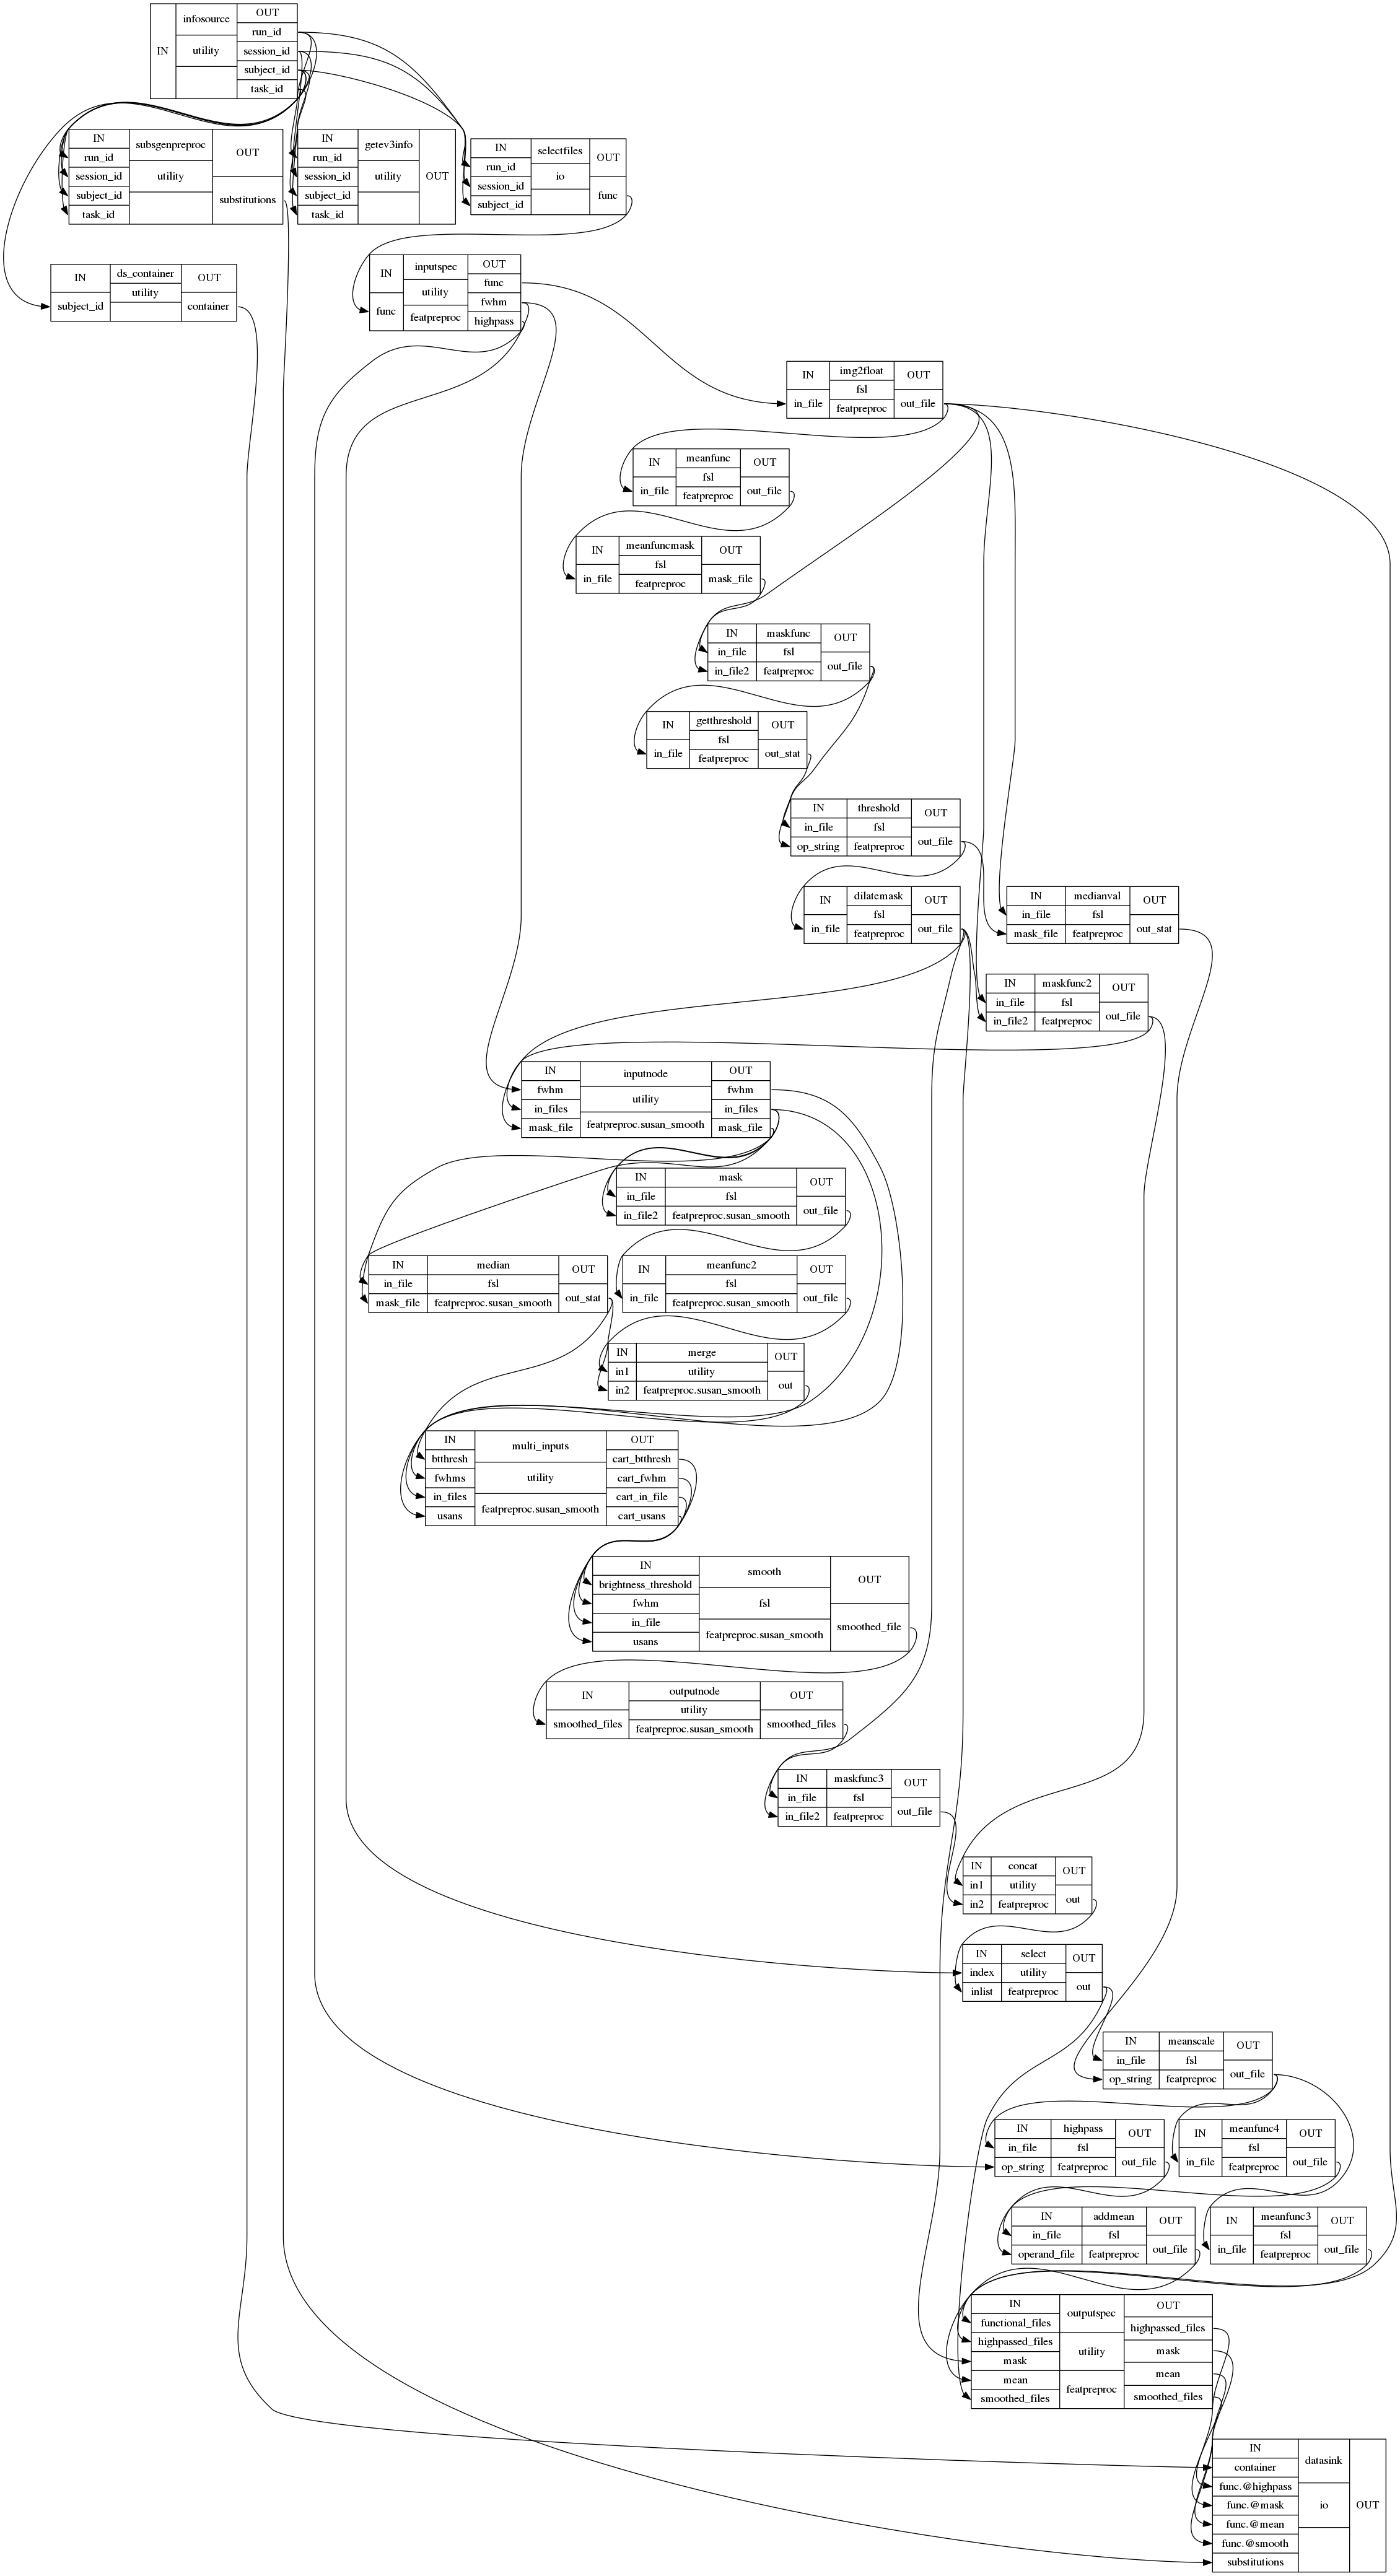

In [11]:
pre.write_graph(graph2use='flat', dotfilename='preproc_wf')
from IPython.display import Image
Image(filename="preproc_wf_detailed.png")

In [12]:
work_dir = opj(experiment_dir, 'workdir')
pre.base_dir = work_dir
pre.run()


181029-14:46:08,0 nipype.workflow INFO:
	 Workflow preprocessing settings: ['check', 'execution', 'logging', 'monitoring']
181029-14:46:08,34 nipype.workflow INFO:
	 Running serially.
181029-14:46:08,36 nipype.workflow INFO:
	 [Node] Setting-up "preprocessing.selectfiles" in "/home/adina/Documents/MasterMagdeburg/USA_Dartmouth/content/localizer_project/BIDS_sacc/workdir/preprocessing/_run_id_run-1_session_id_ses-movie_subject_id_sub-01_task_id_task-avmovie/selectfiles".
181029-14:46:08,40 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
181029-14:46:08,48 nipype.workflow INFO:
	 [Node] Finished "preprocessing.selectfiles".
181029-14:46:08,56 nipype.workflow INFO:
	 [Node] Setting-up "preprocessing.featpreproc.img2float" in "/home/adina/Documents/MasterMagdeburg/USA_Dartmouth/content/localizer_project/BIDS_sacc/workdir/preprocessing/featpreproc/_run_id_run-1_session_id_ses-movie_subject_id_sub-01_task_id_task-avmovie/img2float".
181029-14:46:08,6

181029-14:46:08,191 nipype.workflow INFO:
	 [Node] Cached "preprocessing.featpreproc.select" - collecting precomputed outputs
181029-14:46:08,192 nipype.workflow INFO:
	 [Node] "preprocessing.featpreproc.select" found cached.
181029-14:46:08,193 nipype.workflow INFO:
	 [Node] Setting-up "preprocessing.featpreproc.medianval" in "/home/adina/Documents/MasterMagdeburg/USA_Dartmouth/content/localizer_project/BIDS_sacc/workdir/preprocessing/featpreproc/_run_id_run-1_session_id_ses-movie_subject_id_sub-01_task_id_task-avmovie/medianval".
181029-14:46:08,199 nipype.workflow INFO:
	 [Node] "preprocessing.featpreproc.medianval" found cached.
181029-14:46:08,200 nipype.workflow INFO:
	 [Node] Setting-up "preprocessing.featpreproc.meanscale" in "/home/adina/Documents/MasterMagdeburg/USA_Dartmouth/content/localizer_project/BIDS_sacc/workdir/preprocessing/featpreproc/_run_id_run-1_session_id_ses-movie_subject_id_sub-01_task_id_task-avmovie/meanscale".
181029-14:46:08,206 nipype.workflow INFO:
	 [No

In [13]:
subject_list=[subject_id]
subject_list

['sub-01']

In [14]:
!nipypecli crash /home/adina/Documents/MasterMagdeburg/USA_Dartmouth/content/localizer_project/BIDS_sacc/code/crash-20181029-140330-adina-getev3info.a0-85cb0134-51d0-4189-bb3e-5a0c3de9dace.pklz



File: /home/adina/Documents/MasterMagdeburg/USA_Dartmouth/content/localizer_project/BIDS_sacc/code/crash-20181029-140330-adina-getev3info.a0-85cb0134-51d0-4189-bb3e-5a0c3de9dace.pklz
Node: preprocessing.getev3info
Working directory: /home/adina/Documents/MasterMagdeburg/USA_Dartmouth/content/localizer_project/BIDS_sacc/workdir/preprocessing/_run_id_run-1_session_id_ses-movie_subject_id_sub-01_task_id_task-avmovie/getev3info


Node inputs:

confinfo = ses-movie/func
experiment_dir = /home/adina/Documents/MasterMagdeburg/USA_Dartmouth/content/localizer_project/BIDS_sacc
eyemovement_dir = eyetrack
function_str = def ev3_info(subject_id,
            run_id,
            confinfo,
            experiment_dir,
            session,
            task,
            eyemovement_dir): #TODO: information in infonode and argparse
    """
    This function creates ev3 files from classified/labeled eyemovements,
    extracts information from the ev3 files about 'conditions', onsets and
    durations an

In [15]:
os.getcwd()

'/home/adina/Documents/MasterMagdeburg/USA_Dartmouth/content/localizer_project/BIDS_sacc/code'